In [14]:
#import section
from pathlib import Path
import pandas as pd
import numpy as np
import os
from IPython.display import Image
from datetime import datetime
import hkvsobekpy as hkv
#from hkvsobekpy import WaterstandStatistiek
#from hkvtools.waterstandstatistiek import WaterstandStatistiek
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

In [15]:
# define function
def readGem(sbkDir, sbkFle, sbkLoc, dteFrom, dteTo):
    """
    Read parameter from sobek outputfile

    Parameters
    ----------
    sbkDir : sobek directory
    """
    
    rdFlow = hkv.read_his.ReadMetadata(os.path.join(sbkDir, sbkFle))
    locaties = np.asarray(rdFlow.GetLocations())
    tijdstappen = rdFlow.GetTimestamps()
    parameters = rdFlow.GetParameters()
        
    uitlezen = (np.intersect1d(locaties, sbkLoc)).tolist()
    df_Hour = rdFlow.MultiWaardenArray(uitlezen,parameters,startMMdd=(1, 1),endMMdd=(12, 31),jaarmax_as='none',drop_lege_jaren=False)

    df_Hour = df_Hour.loc[dteFrom:dteTo, :]
    df_Hour['day']   = [idx.day for idx in df_Hour.index]
    df_Hour['month'] = [idx.month for idx in df_Hour.index]
    df_Hour['year']  = [idx.year for idx in df_Hour.index]

    df_Day = df_Hour.groupby(['year','month','day']).sum()/24
    df_Day.index = [datetime.strptime(str(idx), '(%Y, %m, %d)') for idx in df_Day.index]
    tijdsreeks = ((df_Day.index.values >= np.datetime64(dteFrom)) & (df_Day.index.values < np.datetime64(dteTo)))
    df_Day= df_Day.loc[tijdsreeks]
        
    return df_Day

In [16]:
from_date = '2017-03-31'
from_date = datetime.strptime(from_date,'%Y-%m-%d')
to_date   = '2018-04-1'
to_date = datetime.strptime(to_date, '%Y-%m-%d')
year_balans = '2018'

In [17]:
sobek_path = r'D:\Users\Botterhuis\Werk\Pr\3777_10\werk\waterbalans\sbk214\HHSKRAIN.lit\9'
output_path = r'D:\Users\Botterhuis\Werk\Pr\3777_10\werk\test'


In [18]:
#gemalen list  {Code,Type,Gebied,Gemaal,Cap_mm,Cap_ms,Nr_pomp,Cd_pomp,Cp_pomp,In_peil,Uit_peil,St_peil}
file = r'D:\Users\Botterhuis\Software\Jupyter notebooks\PR3777.10 Waterbalans\conf\Overzicht_gemalen.csv'
df_data = pd.read_csv(file, header=0) 
df_select = df_data[(df_data['Code'] == 'KGM-14')]
ar_row = df_select.iloc[0]
ar_row

Code                    KGM-14
Type                    polder
Gebied      Binnenwegse Polder
Gemaal      Binnenwegse Polder
Cap_mm                     173
Cap_ms                 2.88333
Nr_pomp                      3
Cd_pomp               KGM-14p1
Cp_pomp                  0.961
In_peil                     -6
Uit_peil                 -6.04
St_peil                     -6
Bo_peil                  -1.07
Name: 13, dtype: object

In [19]:
#peilvakken list 
#gemalen list  {Code,Type,Gebied,Gemaal,Cap_mm,Cap_ms,Nr_pomp,Cd_pomp,Cp_pomp,In_peil,Uit_peil,St_peil}
file = r'D:\Users\Botterhuis\Software\Jupyter notebooks\PR3777.10 Waterbalans\conf\Overzicht_gemalen.csv'
df_data = pd.read_csv(file, header=0) 

alf_smpl = []
for locid, df_select in df_data.groupby('Code') :  
    #get administration
    Gemaal = df_select.iloc[0]['Code']
    Gebied =  df_select.iloc[0]['Gemaal']
    fle = Path(r'D:\Users\Botterhuis\Software\Jupyter notebooks\PR3777.10 Waterbalans\conf\{}_Peilvak_Afvoergebied.csv'.format(Gemaal))
    if fle.exists():
        data = pd.read_csv(fle, header=0) 
        lijst = data['CODE'].tolist()
        #nodes
        Gebied_UP = ['up'+str(idx) for idx in lijst]
        Gebied_UP = np.asarray(Gebied_UP)
        Gebied_PV = ['pv'+str(idx) for idx in lijst]
        Gebied_PV = np.asarray(Gebied_PV)
        Gebied_GR = ['gr'+str(idx) for idx in lijst]
        Gebied_GR = np.asarray(Gebied_GR)
        #links
        Links_UP = ['brchup'+str(idx) for idx in lijst]
        Links_UP = np.asarray(Links_UP)
        Links_PV = ['brchpv'+str(idx) for idx in lijst]
        Links_PV = np.asarray(Links_PV)
        Links_GR = ['brchgr'+str(idx) for idx in lijst]
        Links_GR = np.asarray(Links_GR)
        #pumps
        Gemaal_GB =['{}'.format(Gemaal), '{}p1'.format(Gemaal), '{}p2'.format(Gemaal), '{}p3'.format(Gemaal), '{}p4'.format(Gemaal)] 
        Inlaat_GB =['f{}'.format(Gemaal), 'i{}'.format(Gemaal)]
        #get data
        Reflow = hkv.read_his.ReadMetadata(os.path.join(sobek_path, '3BAREAS.HIS'))
        locaties = Reflow.GetLocations()
        params = ['Node area (ha)      ']
        #unpaved area
        uitlezen = (np.intersect1d(locaties, Gebied_UP)).tolist()
        df_area = Reflow.MultiWaardenArray(uitlezen,params,startMMdd=(1, 1),endMMdd=(12, 31),jaarmax_as='none',drop_lege_jaren=False)
        areaUP = df_area.sum(axis =1)[0]
        areaUP = areaUP*10000 # naar m^2
        #paved area
        uitlezen = (np.intersect1d(locaties, Gebied_PV)).tolist()
        df_area = Reflow.MultiWaardenArray(uitlezen,params,startMMdd=(1, 1),endMMdd=(12, 31),jaarmax_as='none',drop_lege_jaren=False)
        areaPV = df_area.sum(axis =1)[0]
        areaPV = areaPV*10000 # naar m^2
        #greenhouse area
        uitlezen = (np.intersect1d(locaties, Gebied_GR)).tolist()
        df_area = Reflow.MultiWaardenArray(locaties,params,startMMdd=(1, 1),endMMdd=(12, 31),jaarmax_as='none',drop_lege_jaren=False)
        areaGR = df_area.sum(axis =1)[0]
        areaGR = areaGR*10000 # naar m^2
        #total area
        areaTO = areaUP + areaPV + areaGR
    
        # store sample (file administration)
        alf_row = "{0}, {1}, {2}, {3}, {4}, {5}".format(
                Gemaal, Gebied, areaTO, areaUP, areaPV, areaGR)
        alf_smpl.append(alf_row)
    
        
# write file
alf_fle= r'{out_dir}\oppervlak.csv'.format(out_dir=output_path)
with open(alf_fle, 'w') as file_handler:
    file_handler.write("\n".join(str(item) for item in alf_smpl))    


# Oppervlak

## Afvoer (gemaal)

In [8]:
## Gebied  
df_pump_GB6 = readGem(sobek_path, 'PUMP.HIS', Gemaal_GB, from_date, to_date)

df_pump_GB6.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\base.py:331: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)


parameters Suction-Side Level (m AD)                      \
locations                     KGM-14  KGM-14p1  KGM-14p2   
2017-03-31                 -6.008994 -6.008994 -6.008994   
2017-04-01                 -6.031429 -6.031429 -6.031429   
2017-04-02                 -6.014415 -6.014415 -6.014415   
2017-04-03                 -6.019121 -6.019121 -6.019121   
2017-04-04                 -6.026552 -6.026552 -6.026552   

parameters Delivery-Side Level (m AD)                      \
locations                      KGM-14  KGM-14p1  KGM-14p2   
2017-03-31                  -1.057340 -1.057340 -1.057340   
2017-04-01                  -1.063860 -1.063860 -1.063860   
2017-04-02                  -1.066376 -1.066376 -1.066376   
2017-04-03                  -1.062306 -1.062306 -1.062306   
2017-04-04                  -1.070914 -1.070914 -1.070914   

parameters Pump Head (m)                            Actual Pump Stage (-)  \
locations                KGM-14  KGM-14p1  KGM-14p2                KGM-14   
2017-03-31             4.951654  4.951654  4.951654                  -1.0   
2017-04-01             4.967570  4.967570  4.967570                  -1.0   
2017-04-02             4.948039  4.948039  4.948039                  -1.0   
2017-04-03             4.956815  4.956815  4.956815                  -1.0   
2017-04-04             4.955637  4.955637  4.955637                  -1.0   

parameters   ...             Pump Capacity (m3/s)                          \
locations    ...    KGM-14p2               KGM-14    KGM-14p1    KGM-14p2   
2017-03-31   ...        -1.0          -666.345312 -999.999023 -999.999023   
2017-04-01   ...        -1.0          -999.999023 -999.999023 -999.999023   
2017-04-02   ...        -1.0          -999.999023 -999.999023 -999.999023   
2017-04-03   ...        -1.0          -666.345312 -999.999023 -999.999023   
2017-04-04   ...        -1.0          -999.999023 -999.999023 -999.999023   

parameters Reduction Factor (-)                   Pump Discharge (m3/s)  \
locations                KGM-14 KGM-14p1 KGM-14p2                KGM-14   
2017-03-31                  1.0      1.0      1.0              0.320704   
2017-04-01                  1.0      1.0      1.0              0.000000   
2017-04-02                  1.0      1.0      1.0              0.000000   
2017-04-03                  1.0      1.0      1.0              0.320704   
2017-04-04                  1.0      1.0      1.0              0.000000   

parameters                    
locations  KGM-14p1 KGM-14p2  
2017-03-31      0.0      0.0  
2017-04-01      0.0      0.0  
2017-04-02      0.0      0.0  
2017-04-03      0.0      0.0  
2017-04-04      0.0      0.0  

[5 rows x 21 columns]

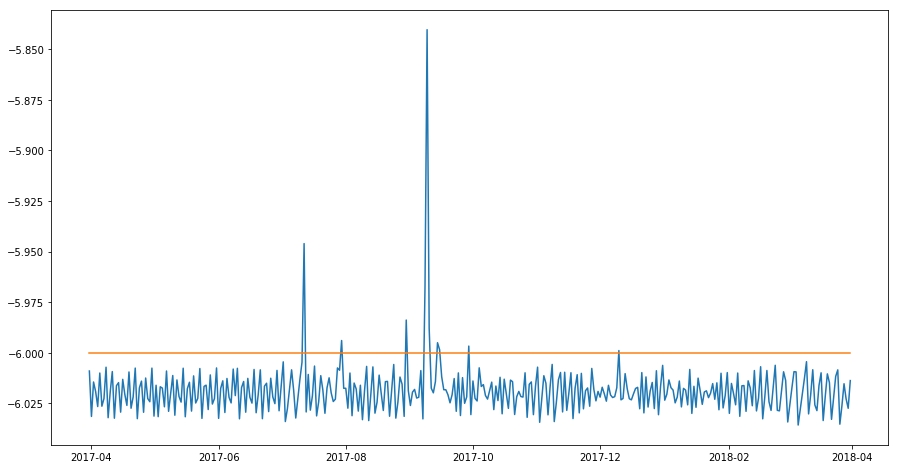

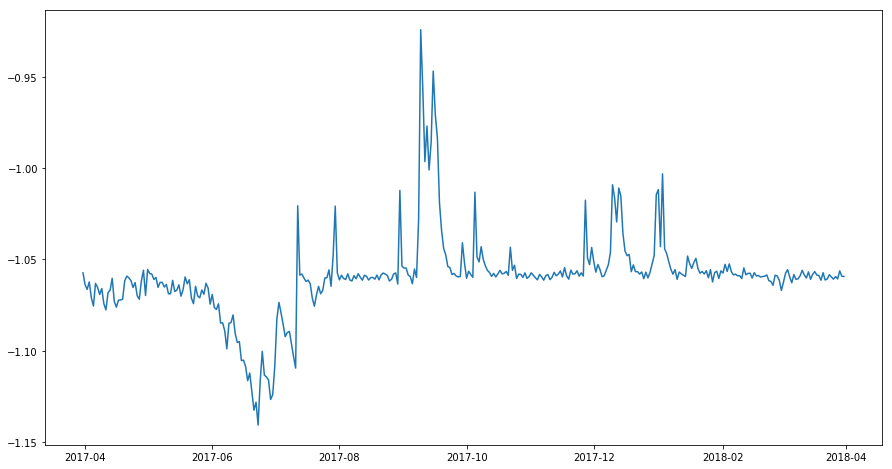

In [9]:
fig1 = plt.figure(figsize = (15,8))
plt.plot(df_pump_GB6.index.values, df_pump_GB6[('Suction-Side Level (m AD)','KGM-14')], label = 'ws polder')
df_dum = df_pump_GB6[('Suction-Side Level (m AD)','KGM-14')]*0 + ft_Peil
plt.plot(df_dum.index.values, df_dum[:], label = 'ws polder')
fig2 = plt.figure(figsize = (15,8))
plt.plot(df_pump_GB6.index.values, df_pump_GB6[('Delivery-Side Level (m AD)','KGM-14')], label = 'ws boezem')

#grfTitle = 'Afvoer gemaal %s %s-%s'%(Gebied,str(from_date)[0:4],str(to_date)[0:4])
#plt.title(grfTitle, fontsize = 20)
#plt.ylabel('mm', fontsize = 18)
#plt.legend(loc = 'best', fontsize = 16)
#text = 'Balans term 1-4-%s: %s mm'%(year_balans,str(int(df_dag['balans_LK'][-1])))
#plt.figtext(x=0.65, y=0.60, s=text, fontsize=16)
#plt.savefig(grfTitle)


In [10]:
ft_Peil


-6.0